# SPASE Record Analysis - How to Use <br>
Author: Zach Boquet

**START HERE**. For documentation on how to add to this project, view the related notebook named "HowToAdd.ipynb" <br>
<br>
This project provides a method to analyze FAIR for the SPASE records in the NumericalData and DisplayData categories.<br>

This notebook shows you how to convert desired SPASE record fields into a SQLite database. The desired fields correspond to metadata extracted from XML files using ElementTree. Also shown is how to query data from that database. <br> 
- The tutorial I used to implement ElementTree is <a href="https://realpython.com/python-xml-parser/" target="_blank">https://realpython.com/python-xml-parser/</a>. 
- If more context is needed for the SQLite code than is provided by the comments, I recommend visiting <a href="https://www.sqlitetutorial.net/" target="_blank">https://www.sqlitetutorial.net/</a>.<br>

*Note that this code was extensively tested on the NASA SPASE Github repo. However, results are not guaranteed when running on other SPASE Github repos. This code was tested in Summer 2024 on SPASE version 2.6.1*

First, clone the NASA SPASE Github Repository <a href="https://github.com/hpde/NASA/tree/master" target="_blank">https://github.com/hpde/NASA/tree/master</a> by executing the following code. Lastly, make sure you have the necessary packages and Python scripts imported below, which can be found in the same repo you found this notebook, linked again here: <a href="https://github.com/Kurokio/HDRL-Internship-2024" target="_blank">https://github.com/Kurokio/HDRL-Internship-2024</a>.

This program takes ~3.88 minutes (233 seconds) to fully run from scratch on over 3000 records.

You can also run the program using older database files found in the repo history. Simply change the name of the parameter to the create_sqlite_database function in the first cell to the name of the .db file you wish to use.

In [ ]:
# install the analysis script locally
# ! pip install ../../HDRL-Internship-2024

# if you intend to modify the scripts use the following command instead
# you may need to restart the kernel before proceeding.
#! pip install -e ../../HDRL-Internship-2024

In [ ]:
# clone NASA SPASE Github Repo into the directory above this tutorial.
! git clone -b master --single-branch --depth=1 https://github.com/hpde/NASA ../../NASA

In [ ]:
# show your current directory
! pwd

## Scraping the SPASE records and populating our tables

This code block performs the following: <br>

- takes the absolute path of a SPASE directory they wish to be scraped as an argument<br>
- finds all desired metadata <br>
- creates all needed tables <br>
- adds an entry for each record found into the MetadataEntries table. <br>
- stores the locations of where each metadata field is found in the MetadataSources table <br>
- adds entries into the Records table with general info and info needed for database maintenance.<br>
- populate the TestResults table with default values. <br>
- update the columns associated with a given analysis test (i.e records that have authors -> has_author column) to have a 'True' value of 1.<br>
<br>

If you want a full printout of everything being done, pass True as the printFlag argument to Create.<br>

Examples are also found as comments at the bottom of the code block to test smaller, yet complex directories.<br>

*Note that this code was designed to work for the NumericalData and DisplayData directories, so inputting directories besides those two may cause logical errors and produce unintended results.*

In [ ]:
import Scripts
from Scripts import create_sqlite_database

help(create_sqlite_database)

In [ ]:
# input abs path of database file you wish to query from, located one directory above this notebook
conn = create_sqlite_database("../SPASE_Data_20240716.db")

Use the next two blocks if you wish to update the database. Otherwise, skip to the next section.

In [ ]:
# import main Python function
from Scripts import Create
#from SQLiteFun import executionALL

help(Create)

In [ ]:
# run these lines first if want to start from scratch
#from Scripts import executionALL
#executionALL("DROP TABLE MetadataEntries", conn)
#executionALL("DROP TABLE MetadataSources", conn)
#executionALL("DROP TABLE Records", conn)
#executionALL("DROP TABLE TestResults", conn)

# updates current records from this directory in the MetadataEntries table
Create('../../NASA/NumericalData', conn)
print('Completed the NumericalData directory.')
Create('../../NASA/DisplayData', conn)

test paths : 
Overall paths: ../../NASA/NumericalData 
AND ../../NASA/DisplayData

Smaller subdirectory = "../../NASA/NumericalData/DE2" 
OR Bigger subdirectory = "../../NASA/NumericalData/ACE"

complex author ex: ../../NASA/NumericalData/Cassini/MAG/PT60S.xml 
OR ../../NASA/NumericalData/ACE/Attitude/Definitive/PT1H.xml

complex URL ex: ../../NASA/NumericalData/ACE/CRIS/L2/P1D.xml

### Understanding the structure
This code block shows you all the table names and their column names in the database that was used.

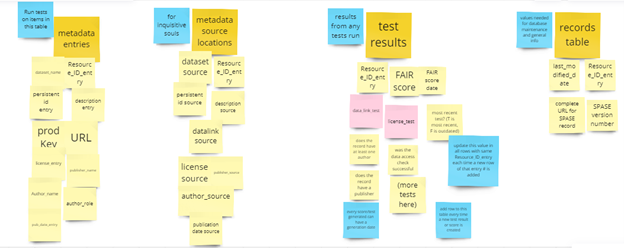

In [ ]:
from Scripts import databaseInfo

help(databaseInfo)

In [ ]:
databaseInfo(conn)

## Executing Analysis Tests and Viewing the Results 
In this code block, we perform calls to the QueryPrinter script to get the Counts and/or ID's of the SPASE records that pass each analysis test. 
These analysis tests include links that have: <br> 

- authors <br>
- publishers <br>
- publication years <br>
- dataset names <br>
- licenses <br>
- URLs <br>
- NASA URLs <br>
- persistent identifiers <br>
- descriptions <br>
- citation info <br>
- DCAT-3 compliance info.<br>

In [ ]:
from Scripts import View
# this function returns all records that pass associated tests 
# and prints the counts of those that pass the test specified in the argument
help(View)

In [ ]:
# example that returns values for one test
records = View(conn, desired = ['Citation'])

In [ ]:
# example that returns values for 4 tests
records = View(conn, desired = ['Author', 'Publisher', 'NASA URL', 'Compliance'])

In [ ]:
# example that returns values for all tests
records = View(conn)

In [ ]:
# understanding the structure of the records dictionary returned
for key in records.keys():
    if len(records[key]) > 0:
        print(key, len(records[key]), records[key][0])
    else:
        print(key, len(records[key]))

### Analysis for All Records

In [ ]:
# This function creates a bar chart for the metadata fields checked.
from Scripts import MetadataBarChart

help(MetadataBarChart)

In [ ]:
# Use the records item returned by the default View(conn) command here
fig = MetadataBarChart(conn, records)

In [ ]:
fig = MetadataBarChart(conn, records, percent = True)

### Analysis for Records with NASA URLs

In [ ]:
# same but only for records with NASA URLs
records = View(conn, All = False)

In [ ]:
fig = MetadataBarChart(conn, records, All = False)

In [ ]:
fig = MetadataBarChart(conn, records, percent = True, All = False)

## Calculating the FAIR Scores
This code overwrites the default values placed in the TestResults table to have the actual FAIR Scores that are calculated according to the following algorithm:<br>

- +1 for author
- +1 for dataset name
- +1 for publication year
- +1 for publisher
- +1 for citation info
- +1 for description
- +1 for PID
- +1 for compliance
- +1 for license
- +1 for NASA URL <br>
======================= <br>
- Total Possible Points of 10

*Note that this alogrithm is expected to change*

If interested in viewing the FAIR Score for a particular record, refer to the column-specific queries section further below.

In [ ]:
from Scripts import databaseInfo

# reminder of how TestResults looks
# REPLACE w updated function to show just TestResults table
databaseInfo(conn)

In [ ]:
from Scripts import FAIRScorer

help(FAIRScorer)

In [ ]:
# calculate FAIR scores for all records
FAIRScorer(records['all'], conn)

In [ ]:
from Scripts import FAIR_Chart

help(FAIR_Chart)

### FAIR Analysis for All Records

In [ ]:
# display FAIR Score Distribution Chart
# all records
FAIR_Chart(conn)

### FAIR Analysis for Records with NASA URLs

In [ ]:
# only records with NASA URLs
FAIR_Chart(conn, All = False)

## How to do your own queries 
This section gives examples of how to query the database for row specific and column specific queries. Also provided are brief explanations of some of the SQLite syntax and also an example of a complex query for both categories. <br>

If more context is needed for the SQLite code than is provided by the comments, I recommend visiting <a href="https://www.sqlitetutorial.net/" target="_blank">https://www.sqlitetutorial.net/</a>.<br>

*Disclaimer: Not all authors are provided, as checks were only done to find if an allowed author exists.* 
<br>
**Also note that when a SPASE record has multiple product keys for one URL or multiple URLs in general, each URL/product key gets their own entry into the table. This is why there may be 'duplicate entries' in the database.**

### Record Specific Queries

This section describes how to get data with queries based on records/rows.

In [ ]:
from Scripts import execution

help(execution)

> Ex: How to get a ResourceID

> - Use """SELECT columnName FROM TableName WHERE columnName = x""" where x is of proper data type.

In [ ]:
stmt = """ SELECT SPASE_id FROM MetadataEntries WHERE rowNum = 10 """
execution(stmt, conn)

> Ex: Get ResourceID by specifying the xml file name

> - Use "LIKE '%text%'" instead of '= x' for when you need to query on partial info.

> - SQLite uses the '%' as the multi-character wildcard and '_' as the single character wildcard.

> - Use DISTINCT to prevent duplicate rows.

In [ ]:
stmt = """ SELECT DISTINCT(SPASE_id) FROM MetadataEntries WHERE SPASE_id LIKE '%IMAP3/PT120S' """
execution(stmt, conn)

> Ex: Searching table for ResourceID using a specific value of a column

In [ ]:
ds = "Interball Aurora MAG 2-min Key Parameters"
stmt = f""" SELECT DISTINCT(SPASE_id) FROM MetadataEntries WHERE datasetName = '{ds}' """
execution(stmt, conn)

> Ex: How to get all data for a SPASE record using the ResourceID
> - Put 'multiple' as the second optional arg for execution when selecting more than 1 item.

>> This example prints out the following data in a list of tuples, where each tuple is a distinct row in the table. The tuples follow the following printout format:
>> - rowNum
>> - SPASE_id
>> - author
>> - authorRole (if relevant)
>> - publisher
>> - publication year
>> - datasetName
>> - license
>> - url (if NASA URL)
>> - prodKey
>> - description
>> - PID

In [ ]:
ID = "spase://NASA/NumericalData/Interball-2/IMAP3/PT120S"
stmt = f""" SELECT * FROM MetadataEntries WHERE SPASE_id = '{ID}' """
rows = execution(stmt, conn, "multiple")
rows

> To get the actual description, use the SPASE_DataPrinter function

In [ ]:
from Scripts import MetadataPrinter

help(MetadataPrinter)

In [ ]:
MetadataPrinter(ID, fields = ["description"])

> Ex: How to get the Fair Score for a record

In [ ]:
ID = "spase://NASA/NumericalData/Interball-2/IMAP3/PT120S"
stmt = f""" SELECT DISTINCT(FAIR_Score) FROM TestResults WHERE SPASE_id = '{ID}' """
execution(stmt, conn)

> Complex example: Selecting multiple items from multiple tables by using the ResourceID

> - Notice we use commas for multiple items and INNER JOINS when it is over multiple tables.

In [ ]:
ID = "spase://NASA/NumericalData/Interball-2/IMAP3/PT120S"
rows = execution(f""" SELECT author, MetadataSources.author_source, Records.SPASE_URL 
            FROM MetadataEntries
                INNER JOIN MetadataSources USING (SPASE_id)
                INNER JOIN Records USING (SPASE_id)
            WHERE SPASE_id = '{ID}';""", conn, 'multiple')
print(rows[0])

### Column Specific Queries
This section describes how to get data with queries based on the column values.

> Ex: How many records do not have a NASA URL?

In [ ]:
stmt = """SELECT COUNT(DISTINCT(SPASE_id)) FROM TestResults WHERE has_NASAurl = 0"""
execution(stmt, conn)

> Ex: What are some examples of SPASE_id's of the records that do not have a NASA URL?
> - Use optional LIMIT x at end to limit how many items are selected.

In [ ]:
stmt = """SELECT DISTINCT(SPASE_id) FROM TestResults WHERE has_NASAurl = 0 LIMIT 10"""
execution(stmt, conn)

> Ex: How many records have 3 out of 4 fields needed for citation?
> - Use AND and OR operators just like in programming languages.

In [ ]:
stmt = """SELECT COUNT(DISTINCT SPASE_id) FROM TestResults 
                WHERE (has_author = 1 
                AND has_datasetName = 1
                AND has_pubYr = 1)
                OR (has_author = 1 
                AND has_datasetName = 1
                AND has_pub = 1)
                OR (has_author = 1 
                AND has_pub = 1
                AND has_pubYr = 1)
                OR (has_datasetName = 1 
                AND has_pub = 1
                AND has_pubYr = 1)"""
execution(stmt, conn)

> Ex: How many records have SDAC or SPDF as a publisher?

In [ ]:
SDAC_stmt = """SELECT COUNT(DISTINCT SPASE_id) FROM MetadataEntries 
                        WHERE (publisher LIKE "%SDAC" OR publisher LIKE 
                                "%Solar Data Analysis Center")"""
SPDF_stmt = """SELECT COUNT(DISTINCT SPASE_id) FROM MetadataEntries 
                        WHERE (publisher LIKE "%SPDF" OR publisher LIKE 
                                "%Space Physics Data Facility")"""
execution(SPDF_stmt, conn)

> Ex: How did records in a certain directory do in terms of FAIR scores?
> - Notice that since we are only interested in the most up-to-date FAIR scores, we add the "MostRecent = 'T'" condition.

In [ ]:
stmt = """SELECT DISTINCT(SPASE_id), FAIR_Score FROM TestResults 
                WHERE SPASE_id LIKE '%/ACE/%' AND MostRecent = 'T' LIMIT 10"""
print("Format is as follows: (SPASE_id, FAIR_Score)")
execution(stmt, conn, 'multiple')

> Ex: How many records have a FAIR Score of x?

In [ ]:
stmt = """SELECT COUNT(DISTINCT SPASE_id) FROM TestResults WHERE FAIR_Score = 9 """
execution(stmt, conn)

> Complex Ex: What records have at least 2 of the desired fields?
> - Notice we use f-strings to concatenate strings instead of retyping text.

In [ ]:
has_citation = """author NOT LIKE ""
                    AND datasetName NOT LIKE ""
                    AND publicationYr NOT LIKE ""
                    AND publisher NOT LIKE "" """
citationStmt = f"""SELECT DISTINCT SPASE_id FROM MetadataEntries 
                WHERE {has_citation};"""
has_compliance = """ description NOT LIKE ""
                AND datasetName NOT LIKE ""
                AND PID NOT LIKE "" """
complianceStmt = f"""SELECT DISTINCT SPASE_id FROM MetadataEntries 
                WHERE {has_compliance};"""

# at least 2 fields
AL2Stmt = f"""SELECT DISTINCT SPASE_id FROM MetadataEntries 
                WHERE ({has_citation}
                AND
                    {has_compliance}) 
                OR
                    ({has_citation}
                AND
                    PID NOT LIKE "")
                OR
                    ({has_citation}
                AND
                    license LIKE "%cc0%" OR license LIKE "%Creative Commons Zero v1.0 Universal%")
                OR
                    ({has_compliance}
                AND
                    license LIKE "%cc0%" OR license LIKE "%Creative Commons Zero v1.0 Universal%")
                OR
                    ({has_compliance}
                AND 
                    PID NOT LIKE "")
                OR  
                    (PID NOT LIKE ""
                AND
                    license LIKE "%cc0%" OR license LIKE "%Creative Commons Zero v1.0 Universal%") LIMIT 10;"""

execution(AL2Stmt, conn)

## How to Backup Database
This code generates a backup copy of the live database into a file specified by the filename variable.

*Note that this cannot be run if there is a pending SQL statement or open transaction running.*

In [ ]:
from Scripts import executionALL
help(executionALL)

In [ ]:
filename = "./SPASE_Data_20240716_backup.db"
stmt = f"VACUUM main INTO '{filename}'"
executionALL(stmt, conn)